## 0. Set enviroment

In [19]:
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install segmentation_models==1.0.1
!pip install tensorflow==2.3.1
!pip install keras==2.4.3

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
     |████████████████████████████████| 320.4 MB 136 kB/s eta 0:00:014     |█████████████████▌              | 175.0 MB 8.4 MB/s eta 0:00:18     |██████████████████              | 180.4 MB 8.4 MB/s eta 0:00:17     |█████████████████████▊          | 217.0 MB 10.7 MB/s eta 0:00:10     |██████████████████████▏         | 221.6 MB 10.7 MB/s eta 0:00:10     |███████████████████████▎        | 233.5 MB 12.2 MB/s eta 0:00:08     |███████████████████████▌        | 235.2 MB 12.2 MB/s eta 0:00:07     |█████████████████████

In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [20]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
from tqdm import tqdm
print('tensorflow version:', tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
pd.set_option('display.max_columns', None)

from glob import glob
from PIL import Image

# copy & paste directory into path_common 
path_common = '../'

tensorflow version: 2.3.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 1. Set parameters and util functions

In [16]:
VER = 'v1'
MIN_OVERLAP = 125
MDLS_PATH = f'./models_{VER}'
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
STRATEGY = tf.distribute.get_strategy() 
TTAS = [0, 1, 2]
VOTERS = 1

In [3]:
tiff_lst = glob(os.path.join(path_common, 'data/', '*.tiff'))

In [5]:
def make_grid(shape, window=256, min_overlap=32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype=np.int64) 
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx * ny, 4)

In [6]:
def get_model(backbone, input_shape, loss_type='bce_dice', 
              umodel='unet', classes=1, lr=.001):
    if backbone == 'efficientnetb0':
        weights = f'{MDLS_PATH}/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
    elif backbone == 'efficientnetb1':
        weights = f'{MDLS_PATH}/efficientnet-b1_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
    elif backbone == 'efficientnetb2':
        weights = f'{MDLS_PATH}/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
    elif backbone == 'efficientnetb3':
        weights = f'{MDLS_PATH}/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
    elif backbone == 'resnet34':
        weights = f'{MDLS_PATH}/resnet34_imagenet_1000_no_top.h5'
    else:
        raise AttributeError('mode parameter error')
    with STRATEGY.scope():
        if loss_type == 'bce_dice': 
            loss = bce_dice_loss
        elif loss_type == 'bce_jaccard_loss':
            loss = bce_jaccard_loss
        else:
            raise AttributeError('loss mode parameter error')
        if umodel == 'unet':
            model = Unet(backbone_name=backbone, encoder_weights=weights,
                         input_shape=input_shape,
                         classes=classes, activation='sigmoid')
        elif umodel == 'fpn':
            model = FPN(backbone_name=backbone, encoder_weights=weights,
                        input_shape=input_shape,
                        classes=classes, activation='sigmoid')
        else:
            raise AttributeError('umodel mode parameter error')
        model.compile(
            optimizer=tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate=lr)
            ),
            loss=loss, 
            metrics=[dice_coef]
        )
    return model

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params['bce_weight'] * binary_crossentropy(y_true, y_pred) + \
        (1 - params['bce_weight']) * dice_loss(y_true, y_pred)

In [14]:
def flip(img, axis=0):
    if axis == 1:
        return img[::-1, :, ]
    elif axis == 2:
        return img[:, ::-1, ]
    elif axis == 3:
        return img[::-1, ::-1, ]
    else:
        return img

## 2. Load pre-trained models and predict

In [7]:
with open(f'{MDLS_PATH}/params.json') as file:
    params = json.load(file)
if 'umodel' not in params.keys(): params['umodel'] = 'unet'
print('loaded params:', params)

loaded params: {'version': 'v1', 'folds': 4, 'img_size': 256, 'resize': 5.859375, 'batch_size': 20, 'epochs': 1000, 'patience': 20, 'decay': False, 'backbone': 'efficientnetb2', 'bce_weight': 1.0, 'loss': 'bce_jaccard_loss', 'seed': 2020, 'split': 'group', 'mirror': False, 'aughard': True, 'umodel': 'unet', 'pseudo': '', 'lr': 0.0002, 'shift': False, 'external': '', 'comments': ''}


In [55]:
for tiff in tiff_lst:
    print('-' * 20, tiff, '-' * 20)
    img_data = rasterio.open(tiff, transform=IDNT)
    print('img shape:', img_data.shape)
    if img_data.count != 3:
        print('img file with subdatasets as channels')
        layers = [rasterio.open(subd) for subd in img_data.subdatasets]
    img_preds = np.zeros(img_data.shape, dtype=np.float32)
    tile_size = 256
    tile_resized = 375
    slices = make_grid(
        img_data.shape, 
        window=tile_resized, 
        min_overlap=MIN_OVERLAP
    )
    models = []
    folds = [0, 1, 2, 3]
    for n_fold in folds:
        checkpoint_path = f'{MDLS_PATH}/model_{n_fold}.hdf5'
        model = get_model(
            params['backbone'], 
            input_shape=(tile_size, tile_size, 3),
            loss_type=params['loss'],
            umodel=params['umodel']
        )
        model.load_weights(checkpoint_path)
        models.append(model)
    for (x1, x2, y1, y2) in tqdm(slices, desc=f'{tiff}'):
        if img_data.count == 3: # normal
            img = img_data.read(
                [1, 2, 3], 
                window=Window.from_slices((x1, x2), (y1, y2))
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((tile_resized, tile_resized, 3), dtype=np.uint8)
            for fl in range(3):
                img[:, :, fl] = layers[fl].read(
                    window=Window.from_slices((x1, x2), (y1, y2))
                )
        img = cv2.resize(img, (tile_size, tile_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        pred = np.zeros((tile_size, tile_size), dtype=np.float32)
        for tta_mode in TTAS:
            img_aug = flip(img, axis=tta_mode)
            img_aug = np.expand_dims(img_aug, 0)
            img_aug = img_aug.astype(np.float32) / 255
            pred_aug = np.zeros((tile_size, tile_size), dtype=np.float32)
            for model in models:
                pred_aug += np.squeeze(model.predict(img_aug)) / len(models)
            pred += flip(pred_aug, axis=tta_mode) / len(TTAS)
        pred = cv2.resize(pred, (tile_resized, tile_resized))
        img_preds[x1:x2, y1:y2] = img_preds[x1:x2, y1:y2] + pred
    #         (pred > THRESHOLD).astype(np.uint8)
    # del model, models, img, pred, img_aug, pred_aug; gc.collect()
    print('img max:', np.max(img_preds), '| voters:', VOTERS)
    
    im = Image.fromarray(img_preds>0.5)
    im.save(f"results/{tiff.split('/')[-1].split('.')[0]}_pred.tiff")

    # if img_file == TARGET_IMG:
    #     print('global shift')
    #     img_preds = (img_preds >= VOTERS).astype(np.uint8)
    #     img_preds = global_shift_mask(img_preds, Y_SHFT, X_SHFT)
    # else:
    #     img_preds = (img_preds >= VOTERS).astype(np.uint8)
    # rle_pred = rle_encode_less_memory(img_preds)

    # subm[i_img] = {'id':img_file.replace('.tiff', ''), 'predicted': rle_pred}
    # del img_preds, img_data, rle_pred; gc.collect()

-------------------- ./data/S 050026746_8_PAS.tiff --------------------
img shape: (10000, 3000)


./data/S 050026746_8_PAS.tiff:   0%|          | 0/533 [00:00<?, ?it/s]

./data/S 050026746_8_PAS.tiff: 100%|██████████| 533/533 [04:32<00:00,  1.96it/s]

img max: 3.6642148 | voters: 1


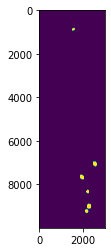

In [62]:
plt.imshow(img_preds>0.5)
plt.show()